# Using dask to export parameters from MCMC HDF5 batches and into ascii file

# Libraries

In [1]:
import sys, os, glob
sys.path.insert(0, '/cobra/ptmp/minh/python_script')
from pathlib import Path

import h5py as h5
import numpy as np
import scipy
import dask
from dask.distributed import Client, LocalCluster
import dask.array as da
import dask.dataframe as dd

import matplotlib
matplotlib.style.use('Minh_paper_style')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, ScalarFormatter, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import ListedColormap
from matplotlib import animation
#from colormap import RdBu_cmap, Planck_cmap
plt.set_cmap('RdBu_r')
plt.rcParams.update({
    "text.usetex": False,
    "font.sans-serif": "Fira Sans",
})

<Figure size 432x288 with 0 Axes>

## Data path

In [27]:
box_label=10
dir_prefix='/cobra/ptmp/minh/lefty_challenge/flatLCDM/box'+ str(box_label)+'/sampling_bO_shat/Eulerian_NUFFT/twolptsecond_nufft/chain'
n_chains=2
chains=['1a','2a']
#dir_prefix='/cobra/ptmp/minh/lefty_challenge/flatLCDM/box1/sampling_bO/Eulerian_NUFFT/twolptsecond_nufft/kmax0125/chain'
#chains=['1_fixed_highsigma_CLASS_largestep','2_fixed_highsigma_CLASS_largestep']
#dir_path=dir_prefix+chains[0]+'/'
dir_path=dir_prefix+chains[1]+'/'
print(dir_path)

/cobra/ptmp/minh/lefty_challenge/flatLCDM/box10/sampling_bO_shat/Eulerian_NUFFT/twolptsecond_nufft/chain2a/


# Get list of chain batches

In [28]:
filename_prefix='sampling_bO_shat_2lptsecond_nufft_FOURIER_NGEul1024_L0.14_cube'

#filename_prefix='sampling_bO_2lptsecond_nufft_FOURIER_NGEul1024_L0.14_cube'
#filename_prefix='sampling_bO_2lptsecond_nufft_FOURIER_NGEul1024_L0.175_cube'
#filename_prefix='sampling_bO_2lptsecond_nufft_FOURIER_NGEul1024_L0.196_cube'
#filename_prefix='sampling_bO_2lptsecond_nufft_FOURIER_NGEul1024_L0.21_cube'

#filename_prefix='sampling_bO_2lptthird_nufft_FOURIER_NGEul1024_L0.14_cube'
#filename_prefix='sampling_bO_2lptthird_nufft_FOURIER_NGEul1024_L0.175_cube'
#filename_prefix='sampling_bO_2lptthird_nufft_FOURIER_NGEul1024_L0.196_cube'
#filename_prefix='sampling_bO_2lptthird_nufft_FOURIER_NGEul1024_L0.21_cube'
p=Path(dir_path)
sorted_filenames=sorted(p.glob(filename_prefix+'.stage3_[1-9]*.h5'), 
                       key=lambda path: int(path.stem.rsplit("cube.stage", 1)[1]))
#sorted_filenames=sorted(p.glob(filename_prefix+'.stage6_[1-9]*.h5'), 
                       #key=lambda path: int(path.stem.rsplit("cube.stage", 1)[1]))
sorted_filenames

[PosixPath('/cobra/ptmp/minh/lefty_challenge/flatLCDM/box10/sampling_bO_shat/Eulerian_NUFFT/twolptsecond_nufft/chain2a/sampling_bO_shat_2lptsecond_nufft_FOURIER_NGEul1024_L0.14_cube.stage3_1.h5'),
 PosixPath('/cobra/ptmp/minh/lefty_challenge/flatLCDM/box10/sampling_bO_shat/Eulerian_NUFFT/twolptsecond_nufft/chain2a/sampling_bO_shat_2lptsecond_nufft_FOURIER_NGEul1024_L0.14_cube.stage3_2.h5'),
 PosixPath('/cobra/ptmp/minh/lefty_challenge/flatLCDM/box10/sampling_bO_shat/Eulerian_NUFFT/twolptsecond_nufft/chain2a/sampling_bO_shat_2lptsecond_nufft_FOURIER_NGEul1024_L0.14_cube.stage3_3.h5'),
 PosixPath('/cobra/ptmp/minh/lefty_challenge/flatLCDM/box10/sampling_bO_shat/Eulerian_NUFFT/twolptsecond_nufft/chain2a/sampling_bO_shat_2lptsecond_nufft_FOURIER_NGEul1024_L0.14_cube.stage3_4.h5'),
 PosixPath('/cobra/ptmp/minh/lefty_challenge/flatLCDM/box10/sampling_bO_shat/Eulerian_NUFFT/twolptsecond_nufft/chain2a/sampling_bO_shat_2lptsecond_nufft_FOURIER_NGEul1024_L0.14_cube.stage3_5.h5'),
 PosixPath('/co

# Define parameter and log-prob lists

## Parameters

In [29]:
with h5.File(sorted_filenames[0],'r') as fhandle:
    param_list=[key for key in fhandle['pars_1991'].keys()]
    shat=fhandle['shat_1991'][()]
    #param_list=[key for key in fhandle['pars_2886'].keys()]
    #shat=fhandle['shat_2886'][()]
    shat_true=fhandle['shat_true'][()]
print(param_list)
print(shat_true.shape)

['alpha', 'b_K^2', 'b_delta', 'b_delta^2', 'b_lapl(delta)', 'sigma', 'sigmaEpsk2', 'sigmaEpsk4']
(90, 90, 90)


## Lagrangian bias parameters

In [30]:
#renamed_param_list=['alpha','b_delta','b_lapl_delta','b_sigmasigma','b_trM1M1','sigma','sigmaEpsk2','sigmaEpsk4']
#latex_param_list=[r'\alpha',r'b_\delta',r'b_{\nabla^2 \delta}',r'b_{\sigma^2}',r'b_{\mathrm{tr}[M^{(1)} M^{(1)}]}',r'\sigma_\epsilon',r'\sigma_{\epsilon_{k^2}}',r'\sigma_{\epsilon_{k^4}}']

## Eulerian bias parameters

### Second order

In [31]:
renamed_param_list=['alpha','b_K2','b_delta','b_delta2','b_lapl(delta)','sigma','sigmaEpsk2','sigmaEpsk4']
latex_param_list=[r'\alpha',r'b_{K^2}',r'b_\delta',r'b_{\delta^2}',r'b_{\nabla^2 \delta}',r'\sigma_\epsilon',r'\sigma_{\epsilon_{k^2}}',r'\sigma_{\epsilon_{k^4}}']

### Third order

In [32]:
#renamed_param_list=['alpha','b_K2','b_K3','b_Otd', 'b_delta', 'b_deltaK2', 'b_delta2', 'b_delta3', 'b_lapl(delta)','sigma','sigmaEpsk2','sigmaEpsk4']
#latex_param_list=[r'\alpha',r'b_{K^2}', r'b_{K^3}', r'b_{\mathrm{Otd}}', r'b_\delta', r'b_{\delta K^2}', r'b_{\delta^2}', r'b_{\delta^3}', r'b_{\nabla^2 \delta}',r'\sigma_\epsilon',r'\sigma_{\epsilon_{k^2}}',r'\sigma_{\epsilon_{k^4}}']

## Log probabilities

In [33]:
logprob_list=['log_like','log_param_prior','log_shat_prior']

# Get parameter and log-prob chains

## Utility functions

In [9]:
def get_param_value_chain(chain,sample_range,param_list=param_list):
    params=np.empty(((sample_range[1]-sample_range[0]+1),len(param_list),))
    params[:]=np.nan
    with h5.File(chain,'r') as fhandle:
        for s,sample in enumerate(np.arange(sample_range[0],sample_range[1]+1,dtype=int)):
            for p, param in enumerate(param_list):
                params[s,p]=fhandle['pars_'+str(sample)][param][0]
    return params

def get_logprob_value_chain(chain,sample_range,logprob_len=3):
    logprob=np.empty(((sample_range[1]-sample_range[0]+1),logprob_len))
    logprob[:]=np.nan
    with h5.File(chain,'r') as fhandle:
        for s,sample in enumerate(np.arange(sample_range[0],sample_range[1]+1,dtype=int)):
            for l in range(logprob_len):
                logprob[s,l]=fhandle['logprobs_'+str(sample)][l]
    return logprob

def get_min_sample_in_batch(batch_path,keyword='sample_range'):
    with h5.File(batch_path) as fhandle:
        min_sample=fhandle['sample_range'][()]
    return min_sample

def get_sample_range_in_batch(batch_path,keyword='pars_'):
    with h5.File(batch_path) as fhandle:
        batch_keys=list(fhandle.keys())
    sample_id = []
    for key in batch_keys:
        if keyword in key:
            sample_id.append(key.replace(keyword,''))
    sample_id = np.asarray(sample_id,dtype=int)
    return np.array([sample_id.min(), sample_id.max()])

def unnest_tuple_of_tuples(nested_tuple):
    return [param for tup in nested_tuple for param in tup]

## Setup dask client

In [10]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(threads_per_worker=4,n_workers=6,memory_limit='30GB')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35027 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 180.00 GB


## Get sample ranges for all MCMC batches

In [34]:
min_sample_futures=client.map(get_min_sample_in_batch,sorted_filenames)
sample_range_futures=client.map(get_sample_range_in_batch,sorted_filenames)

In [35]:
min_sample=np.asarray(client.gather(min_sample_futures));
sample_range=np.asarray(client.gather(sample_range_futures));

## Get parameters and log-probs from all MCMC batches

In [36]:
param_futures=client.map(get_param_value_chain,sorted_filenames,sample_range);
logprob_futures=client.map(get_logprob_value_chain,sorted_filenames,sample_range);

In [37]:
params=client.gather(param_futures)
logprobs=client.gather(logprob_futures)

## Reshape the chains of parameters and log probabilities before output

In [38]:
param_chain=unnest_tuple_of_tuples(params)
param_chain_block=np.block(param_chain)
param_chain_reshaped=param_chain_block.reshape(int(param_chain_block.shape[0]/len(param_list)),len(param_list))

In [39]:
logprob_chain=unnest_tuple_of_tuples(logprobs)
logprob_chain_block=np.block(logprob_chain)
logprob_chain_reshaped=logprob_chain_block.reshape(int(logprob_chain_block.shape[0]/3),3)

## Output param and log-prob chains

In [40]:
param_outfile_path=dir_path+filename_prefix+'_params.'+str(chains[1])+'.txt'
np.savetxt(param_outfile_path,param_chain_reshaped,header='\t'.join(renamed_param_list))

In [41]:
logprob_outfile_path=dir_path+filename_prefix+'_logprobs.'+str(chains[1])+'.txt'
np.savetxt(logprob_outfile_path,logprob_chain_reshaped,header='\t'.join(logprob_list))

In [42]:
paramnames_outfile_path=dir_path+filename_prefix+'_logP_params.paramnames'
f = open(paramnames_outfile_path,'w+')
for par_name,par_latex in zip(renamed_param_list,latex_param_list):
    f.write(par_name+'\t'+par_latex+'\n')
    print(par_latex)
f.close()

\alpha
b_{K^2}
b_\delta
b_{\delta^2}
b_{\nabla^2 \delta}
\sigma_\epsilon
\sigma_{\epsilon_{k^2}}
\sigma_{\epsilon_{k^4}}


In [43]:
cutoff=1000
print(param_chain_reshaped[cutoff:,0].mean())
print(param_chain_reshaped[cutoff:,0].std())

1.002960478170197
0.02254348802377053


## Visual inspections

0.4500000000000001
1.1102230246251565e-16


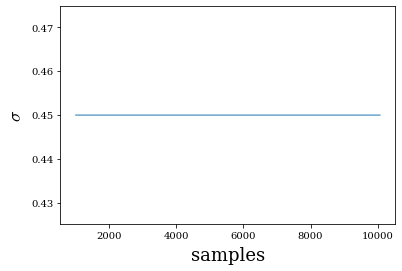

In [44]:
fig,ax=plt.subplots(facecolor='w')
samples=np.arange(0,param_chain_reshaped.shape[0],1)
ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,5])
#ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,9])
ax.set_xlabel(r'samples')
ax.set_ylabel(r'$\sigma$')
#fig_path=r'/cobra/u/minh/Beyond2ptMock/results/figs/'
#fig_name='sigma_trace_stepsize5e-2_twolptthirdNUFFT_Lambda021_kmax015_chain1.pdf'
#plt.savefig(fig_path+fig_name)
print(np.mean(param_chain_reshaped[cutoff:,5]))
print(np.std(param_chain_reshaped[cutoff:,5]))

1.002960478170197
0.02254348802377053


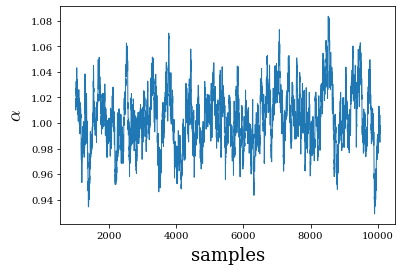

In [45]:
fig,ax=plt.subplots(facecolor='w')
samples=np.arange(0,param_chain_reshaped.shape[0],1)
ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,0],label=r'$k_{\mathrm{max}}=0.10,\Lambda=0.14$')
#ax.set_ylim(0.8970,0.9000)
ax.set_xlabel(r'samples')
ax.set_ylabel(r'$\alpha$')
#ax.legend(frameon=False,fontsize=14,loc='lower left')
#fig_path=r'/cobra/u/minh/Beyond2ptMock/results/figs/'
#fig_name='alpha_trace_alphastepsize1e-3_twolptthirdNUFFT_Lambda021_kmax015_chain2.pdf'
#plt.savefig(fig_path+fig_name)
print(np.mean(param_chain_reshaped[cutoff:,0]))
print(np.std(param_chain_reshaped[cutoff:,0]))

1.7687405897588835
0.04003137351352558


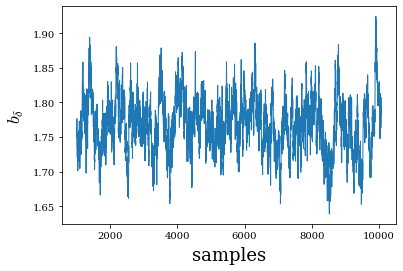

In [46]:
fig,ax=plt.subplots(facecolor='w')
samples=np.arange(0,param_chain_reshaped.shape[0],1)
ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,2],label=r'$k_{\mathrm{max}}=0.10,\Lambda=0.14$')
#ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,4],label=r'$k_{\mathrm{max}}=0.125,\Lambda=0.175$')

#ax.set_ylim(0.8970,0.9000)
ax.set_xlabel(r'samples')
ax.set_ylabel(r'$b_\delta$')
#ax.legend(frameon=False,fontsize=14,loc='lower left')
#fig_path=r'/cobra/u/minh/Beyond2ptMock/results/figs/'
#fig_name='alpha_trace_alphastepsize1e-3_twolptthirdNUFFT_Lambda021_kmax015_chain2.pdf'
#plt.savefig(fig_path+fig_name)
print(np.mean(param_chain_reshaped[cutoff:,2]))
print(np.std(param_chain_reshaped[cutoff:,2]))

708.9733301844043


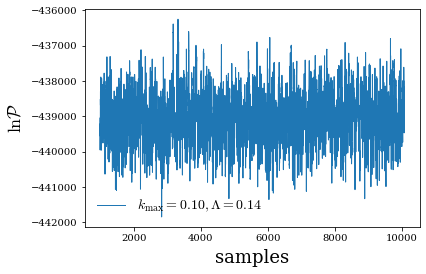

In [47]:
fig,ax=plt.subplots(facecolor='w')
samples=np.arange(0,logprob_chain_reshaped.shape[0],1)
ax.plot(samples[cutoff:],logprob_chain_reshaped[cutoff:,:].sum(axis=1),label=r'$k_{\mathrm{max}}=0.10,\Lambda=0.14$')
ax.set_xlabel(r'samples')
#fig_name='logP_trace_alphastepsize1e-3_twolp'samples')
ax.set_ylabel(r'$\ln\mathcal{P}$')
ax.legend(frameon=False,fontsize=14,loc='lower left')
#fig_path=r'/cobra/u/minh/BeyondtthirdNUFFT_Lambda021_kmax015_chain2.pdf'
#plt.savefig(fig_path+fig_name)
print(np.std(logprob_chain_reshaped[cutoff:,:].sum(axis=1)))

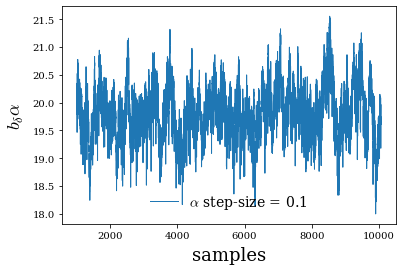

In [48]:
fig,ax=plt.subplots(facecolor='w')
samples=np.arange(0,param_chain_reshaped.shape[0],1)
ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,4]*param_chain_reshaped[cutoff:,0],label=r'$\alpha$ step-size = 0.1')
ax.set_xlabel(r'samples')
ax.set_ylabel(r'$b_{\delta}\alpha$')
ax.legend(frameon=False,fontsize=14)
fig_path=r'/cobra/u/minh/Beyond2ptMock/results/figs/'
fig_name='bdelta_alpha_trace_alphastepsize1e-1_chain1.pdf'
plt.savefig(fig_path+fig_name)

In [49]:
print(param_chain_reshaped[cutoff:,0].mean())
print(param_chain_reshaped[cutoff:,0].std())

1.002960478170197
0.02254348802377053


In [ ]:
fig,ax=plt.subplots(facecolor='w')
samples=np.arange(0,param_chain_reshaped.shape[0],1)
#ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,2])
ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,4])
ax.set_xlabel(r'samples')
ax.set_ylabel(r'$b_\delta$')

In [ ]:
fig,ax=plt.subplots(facecolor='w')
samples=np.arange(0,param_chain_reshaped.shape[0],1)
ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,3])
ax.set_xlabel(r'samples')
ax.set_ylabel(r'$b_{\delta^2}$')

In [ ]:
fig,ax=plt.subplots(facecolor='w')
samples=np.arange(0,param_chain_reshaped.shape[0],1)
ax.plot(samples[cutoff:],param_chain_reshaped[cutoff:,1])
ax.set_xlabel(r'samples')
ax.set_ylabel(r'$b_{K^2}$')